In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt
from solver_linear import Solver

plt.style.use("ggplot")

In [2]:
class Method(enum.Enum):
    '''
        Перечисление для удобного выбора метода
    '''
    DICHOTOMY   = 1
    NEWTON      = 2
    ITER_SIMPLE = 3

class Solver_non_linear:
    """
        Решатель СНЛАУ
    """

    def dichotomy(self, f, x_l, x_r, epsilon=10e-6):
        if(np.sign(f(x_l)) == np.sign(f(x_r))):
            raise RuntimeError("Значения на концах отрезка должны быть разного знака")

        while(True):
            x_m = (x_l + x_r) / 2
            if np.abs(f(x_m) - 0) < epsilon:
                return x_m
            if(f(x_l)*f(x_m) < 0):
                x_r = x_m
            if(f(x_m)*f(x_r) < 0):
                x_l = x_m

    def calc_J(self, F, x, h=None):
        n = len(F)
        if h is None:
            # Если не задали шаг, то по всем направлениям будет h=1e-6
            h =  np.repeat(1e-6, n)
        #  Считаем Якобиан
        J = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                shift = np.zeros_like(h)
                # Делаем сдвиг только по одному из направлений
                shift[j] = h[j]
                # Метод конечных разностей с квадратичной ошибкой
                J[i, j] = (F[i](x + shift) - F[i](x - shift)) / (2*h[i])

        return J

    def calc_F(self, F, x):
        return np.array([F[i](x) for i in range(len(F))])

    def NEWTON(self, F, x, max_iter=100, epsilon=1e-6, h=None):
        x = np.asarray(x).flatten()
        dim = len(F)
        if h is None:
            # Если не задали шаг, то по всем направлениям будет h=1e-6
            h =  np.repeat(1e-6, len(F))

        for _ in range(max_iter):
            F_val = self.calc_F(F, x)
            J_val = self.calc_J(F, x, h)
            # Решаем линейную систему J*delta = -F
            sl = Solver()
            if(dim > 1):
                delta = sl.solve(J_val, -F_val[..., None])
                delta = delta.flatten()
            else:
                delta = float(-F_val / J_val)
            x = x + delta

            # Проверяем условие остановки
            if np.linalg.norm(delta) < epsilon:
                return x
        else:
            RuntimeError("Достигнуто максимальное число итераций.")
    
    def ITER_SIMPLE_Rn(self, F: list, x0: np.array, N=100):
        '''
        Метод простой итерации
    
        Параметры:
            F   - система функций вида: F(x) = 0
            x0  - начальное приближение
            N   - число итерации
        '''
        from norms import norm_matrix
        from norms import NormType
        # x = t*f(x) + x = F(x)
        n = len(F)
        x_n = x0
        for _ in range(N):
            t = (1/(n*2) - 1) * np.linalg.inv(self.calc_J(F, x_n))
            
            # Условие сходимости |F'(x)| < 1
            norm = norm_matrix(t @ self.calc_J(F, x_n) + np.eye(n, n), NormType.INF)
            if norm >= 1:
                raise RuntimeError(f"{norm} The method diverges!!!; |F'(x)| >= 1; Iter_N: {_}")
            
            if n == 1:
                x_n = t[0] @ np.array([F[i](x_n) for i in range(x_n.shape[0])]) + x_n
                continue
            x_n = t @ np.array([F[i](x_n) for i in range(x_n.shape[0])]) + x_n
        
        return x_n

In [3]:
sl = Solver_non_linear()

## Пример метода деления отрезка пополам

Приближенное решение: 1.7048473358154297
Значение в этой точке: 3.298496999981637e-06


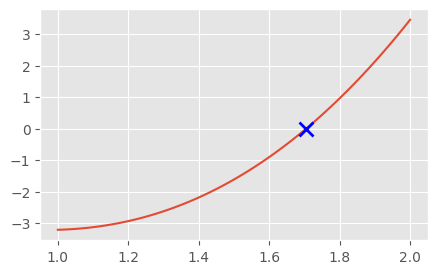

In [4]:
fig, axes = plt.subplots(figsize=(5, 3))
def f(x):
    return x**3 - 5*np.sin(x)

x_left, x_right = 1, 2
x = sl.dichotomy(f, x_left, x_right)
print(f"Приближенное решение: {x}\nЗначение в этой точке: {f(x)}")

N_x = 100
x_arr = np.linspace(x_left, x_right, N_x)
axes.plot(x_arr, f(x_arr));
axes.plot(x, f(x), 'bx', markersize=10, markeredgewidth=2);

## Пример метода Ньютона

## 1D

[-0.72950221]
[2.22044605e-16]


C:\Users\User\AppData\Local\Temp\ipykernel_20852\3178328614.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i, j] = (F[i](x + shift) - F[i](x - shift)) / (2*h[i])
C:\Users\User\AppData\Local\Temp\ipykernel_20852\3178328614.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta = float(-F_val / J_val)


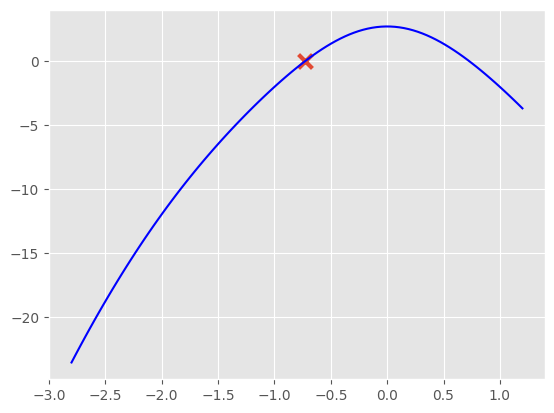

In [5]:
# 1-D
F = [
        lambda x: np.exp(1 - x**2) - 3*x**2 
    ]

# Начальное приближение
x0 = np.array([-0.8])

x_answer = sl.NEWTON(F, x0)
print(x_answer)
print(F[0](x_answer))

x_arr = np.linspace(x0-2, x0+2, 100)

plt.scatter(x_answer, F[0](x_answer), marker='x', s=100, linewidths=3)
plt.plot(x_arr, F[0](x_arr), c='b');

## 2D

In [6]:
# 2-D
F = np.array([
        lambda x: x[0] - x[1]**2,
        lambda x: np.cos(x[0]) - x[1]
    ])

# Начальное приближение
x0 = np.array([0.5, 0.5])

x_ans = sl.NEWTON(F, x0)
print(f"x: {x_ans}\nF(x): {sl.calc_F(F, x_ans)}")

x: [0.64171437 0.80107077]
F(x): [-1.26898492e-13 -8.28226376e-14]


In [7]:
# 2-D
F = np.array([
        lambda x: x[0]**2 + x[1]**2 - 4,
        lambda x: x[1] - x[0]**2 + 2*x[0] - 1
    ])

# Начальное приближение
x0 = np.array([-2, .0])

x_ans = sl.NEWTON(F, x0)
print(f"x: {x_ans}\nF(x): {sl.calc_F(F, x_ans)}")

x: [-0.39986411  1.95961953]
F(x): [0. 0.]


## 3D

In [8]:
# 3-D
F = np.array([
        lambda x: x[0]**2 + x[1]**2 + x[2]**2 - 14,
        lambda x: x[0]*x[1] + x[1]*x[2] - 2*x[0] - 1,
        lambda x: np.exp(x[0]/2) + np.cos(x[0]) + x[2] - 3
    ])
# Начальное приближение
x0 = np.array([1.0, 2.0, 3.0])

x_ans = sl.NEWTON(F, x0)
print(f"x: {x_ans}\nF(x): {sl.calc_F(F, x_ans)}")

x: [ 2.80887178  2.46856985 -0.12807117]
F(x): [1.77635684e-15 0.00000000e+00 0.00000000e+00]


## Пример метода простой итерации

## 1D

C:\Users\User\AppData\Local\Temp\ipykernel_20852\3178328614.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i, j] = (F[i](x + shift) - F[i](x - shift)) / (2*h[i])


Приближенное решение: [1.84140566]
Значение в этой точке: [0.]


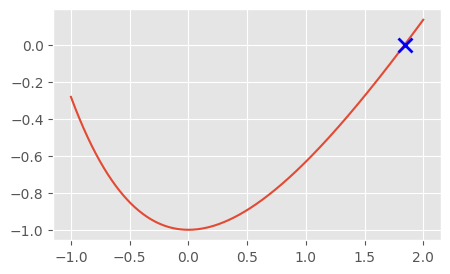

In [9]:
fig, axes = plt.subplots(figsize=(5, 3))
def f(x):
    # return (x-0.5)**2
    return np.exp(-x)-2+x
    # return np.exp(1-x**2) - 3*x**2

def f_graf(x):
    return np.exp(1-x**2) - 3*x**2

x_left, x_right = -1, 2
x = sl.ITER_SIMPLE_Rn([f], np.array([(x_left + x_right)/2]), N=10000)

print(f"Приближенное решение: {x}\nЗначение в этой точке: {f(x)}")

N_x = 10000
x_arr = np.linspace(-1, 2, N_x)
axes.plot(x_arr, f(x_arr));
axes.plot(x, f(x), 'bx', markersize=10, markeredgewidth=2);


## 2D

In [10]:
# 2-D
sl = Solver_non_linear()
F = np.array([
        lambda x: x[0]**2 + x[1]**2 - 4,
        lambda x: x[1] - x[0]**2 + 2*x[0] - 1
    ])

# Начальное приближение
x0 = np.array([0, 2])

x_ans = sl.ITER_SIMPLE_Rn(F, x0)
print(f"x: {x_ans}\nF(x): {sl.calc_F(F, x_ans)}")

x: [-0.39986411  1.95961953]
F(x): [0. 0.]


In [11]:
# 2-D
F = np.array([
        lambda x: x[0] - x[1]**2,
        lambda x: np.cos(x[0]) - x[1]
    ])

# Начальное приближение
x0 = np.array([0.5, 0.5])

x_ans = sl.ITER_SIMPLE_Rn(F, x0)
print(f"x: {x_ans}\nF(x): {sl.calc_F(F, x_ans)}")

x: [0.64171437 0.80107077]
F(x): [0. 0.]


## 3D

In [12]:
# 3-D
F = np.array([
        lambda x: x[0]**2 + x[1]**2 + x[2]**2 - 14,
        lambda x: x[0]*x[1] + x[1]*x[2] - 2*x[0] - 1,
        lambda x: np.exp(x[0]/2) + np.cos(x[0]) + x[2] - 3
    ])
# Начальное приближение
x0 = np.array([1.0, 2.0, 3.0])

x_ans = sl.ITER_SIMPLE_Rn(F, x0)
print(f"x: {x_ans}\nF(x): {sl.calc_F(F, x_ans)}")

x: [ 2.80887178  2.46856985 -0.12807117]
F(x): [-1.77635684e-15  0.00000000e+00 -4.44089210e-16]
